<a href="https://colab.research.google.com/github/MeeTK26/30DaysOfMLDL/blob/main/ComparisionOnTransformerandXGBoost(day30).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

In [43]:
import pandas as pd

df = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)
df.dropna(inplace=True)

In [44]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns[:-1]

In [45]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [46]:
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [47]:
import numpy as np

X = df.drop(columns=["income"]).values
y = df["income"].values
y = np.expand_dims(y, axis=-1)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

In [53]:
inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Reshape((8, 16))(x)
x = transformer_block(x, head_size=64, num_heads=4, ff_dim=128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)



In [54]:
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])



In [55]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7756 - loss: 0.4768 - val_accuracy: 0.8331 - val_loss: 0.3702
Epoch 2/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8264 - loss: 0.3776 - val_accuracy: 0.8497 - val_loss: 0.3377
Epoch 3/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8372 - loss: 0.3460 - val_accuracy: 0.8458 - val_loss: 0.3306
Epoch 4/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8420 - loss: 0.3373 - val_accuracy: 0.8485 - val_loss: 0.3280
Epoch 5/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8430 - loss: 0.3364 - val_accuracy: 0.8449 - val_loss: 0.3296
Epoch 6/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8395 - loss: 0.3381 - val_accuracy: 0.8440 - val_loss: 0.3295
Epoch 7/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8435 - loss: 0.3293 - val_accuracy: 0.8442 - val_loss: 0.3317
Epoch 8/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8412 - loss: 0.3372 - 

In [57]:
_, transformer_acc = model.evaluate(X_test, y_test)



204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8557 - loss: 0.3157


In [60]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train.ravel())

y_pred_xgb = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:32:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


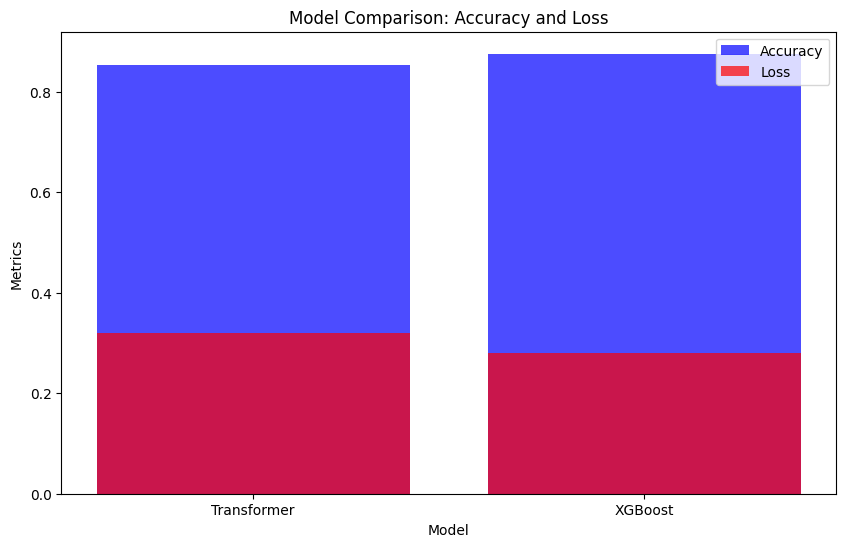

In [62]:

import pandas as pd
import matplotlib.pyplot as plt

loss_transformer = model.evaluate(X_test, y_test, verbose=0)[0]

from sklearn.metrics import log_loss
y_pred_proba_xgb = xgb_model.predict_proba(X_test)
loss_xgb = log_loss(y_test, y_pred_proba_xgb)


results = {
    'Model': ['Transformer', 'XGBoost'],
    'Accuracy': [transformer_acc, xgb_acc],
    'Loss': [loss_transformer, loss_xgb]
}


df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.bar(df_results['Model'], df_results['Accuracy'], label='Accuracy', color='blue', alpha=0.7)
plt.bar(df_results['Model'], df_results['Loss'], label='Loss', color='red', alpha=0.7)

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Model Comparison: Accuracy and Loss')
plt.legend()
plt.show()

